# Decision Tree Analysis on ACES Dataset
This notebook explores the ACES dataset using decision trees. We perform data loading, preprocessing, model training, and evaluation, with a focus on analyzing node accuracies and generating new samples to improve the model.

In [1]:
import scipy.io
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

## Data Loading and Basic Exploration
We begin by loading the dataset from `.mat` files and perform initial exploration to understand the structure and content of the data.

In [2]:
def load_and_prepare_aces_data(base_path):
    expression_data = scipy.io.loadmat(f'{base_path}/ACES_RefinedCommunity_AVG.mat')
    label_data = scipy.io.loadmat(f'{base_path}/ACESLabel.mat')

    # Extract the expression matrix and labels
    expression_matrix = expression_data['data']
    labels = label_data['label'].flatten()  

    # Convert to DataFrame and Series for easy manipulationa
    expression_df = pd.DataFrame(expression_matrix)
    labels_df = pd.Series(labels, name='label')
    
    return expression_df, labels_df

# Example usage
base_path = '/Users/asifahmed/Documents/Codes/MyRecourseProject/datasets/ACES_dataset'
expression_df, labels_df = load_and_prepare_aces_data(base_path)

### Basic Data Information
Display the number of samples and features in the dataset and examine the distribution of labels to understand the class balance.

In [4]:
def basic_data_info(expression_df, labels_df):
    print(f"Number of samples (rows): {expression_df.shape[0]}")
    print(f"Number of genes (columns): {expression_df.shape[1]}")
    print("\nLabels information:")
    print(labels_df.value_counts())

basic_data_info(expression_df, labels_df)

Number of samples (rows): 1616
Number of genes (columns): 37

Labels information:
label
0    1161
1     455
Name: count, dtype: int64


## Train-Test Split
Split the dataset into training and testing sets to evaluate model performance.

In [5]:
def split_data(expression_df, labels_df, test_size=0.2, seed=42):
    X_train, X_test, y_train, y_test = train_test_split(expression_df, labels_df, test_size=test_size, random_state=seed)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(expression_df, labels_df)

# Print sizes and class distributions
print("Training Set Size:", X_train.shape)
print("Test Set Size:", X_test.shape)
print("\nTraining Set Class Distribution:\n", y_train.value_counts(normalize=True))
print("\nTest Set Class Distribution:\n", y_test.value_counts(normalize=True))

Training Set Size: (1292, 37)
Test Set Size: (324, 37)

Training Set Class Distribution:
 label
0    0.724458
1    0.275542
Name: proportion, dtype: float64

Test Set Class Distribution:
 label
0    0.694444
1    0.305556
Name: proportion, dtype: float64


## Hyperparameter Tuning with Cross-Validation
We use a Decision Tree Classifier with grid search to find the best hyperparameters.

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

def perform_grid_search(X_train, y_train, 
                        max_depth=[3, 5, 10, None], 
                        min_samples_split=[2, 5, 10], 
                        min_samples_leaf=[1, 2, 4], 
                        criterion=['gini', 'entropy'], 
                        seed=42, 
                        cv=10, 
                        scoring='accuracy', 
                        verbose=0, 
                        n_jobs=-1):
    
    param_grid = {
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'criterion': criterion
    }
    
    dt = DecisionTreeClassifier(random_state=seed)
    grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, n_jobs=n_jobs)
    grid_search.fit(X_train, y_train)
    return grid_search

# Example usage
grid_search = perform_grid_search(X_train, y_train, max_depth=[3, 5, 7], min_samples_split=[2, 4], min_samples_leaf=[1, 3])
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}


## Model Training

In this section, we train our decision tree model using the best hyperparameters found during hyperparameter tuning.

In [7]:
def train_best_model(grid_search, X_train, y_train):
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)
    return best_model

# Train the model using the best hyperparameters
best_model = train_best_model(grid_search, X_train, y_train)

## Initial Model Evaluation

After training the model, we evaluate its performance on the test set before adjusting the decision threshold. This provides a baseline for how well the model performs with the default threshold of 0.5.


Initial Model Evaluation:
Test Accuracy: 0.70
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.98      0.82       225
           1       0.58      0.07      0.13        99

    accuracy                           0.70       324
   macro avg       0.64      0.52      0.47       324
weighted avg       0.67      0.70      0.61       324



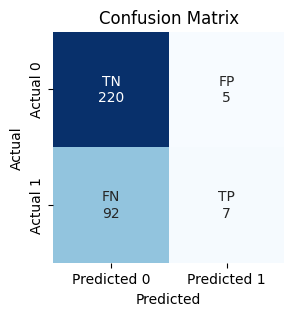

In [8]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
    labels = np.array([["TN", "FP"], ["FN", "TP"]])
    cm_with_labels = np.array([f"{label}\n{cm_val}" for label, cm_val in zip(labels.flatten(), cm.flatten())])
    cm_with_labels = cm_with_labels.reshape(2, 2)
    
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=cm_with_labels, fmt="", cmap='Blues', cbar=False, square=True, 
                xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
    
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
def evaluate_model(best_model, X_test, y_test):
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred)

print("\nInitial Model Evaluation:")
evaluate_model(best_model, X_test, y_test)

## Adjusting Decision Threshold Using Cross-Validation

In this section, we adjust the decision threshold of our model using cross-validation to optimize the F1-score. This allows us to find a threshold that balances precision and recall without reducing the size of our training data.

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

def find_optimal_threshold(model, X, y, cv=10, random_state=42):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    y_proba = np.zeros(len(y))
    for train_index, val_index in skf.split(X, y):
        X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
        y_train_cv = y.iloc[train_index]

        model_clone = clone(model)
        model_clone.fit(X_train_cv, y_train_cv)

        y_proba[val_index] = model_clone.predict_proba(X_val_cv)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    f1_scores = np.nan_to_num(f1_scores)

    optimal_idx = np.argmax(f1_scores)
    best_threshold = thresholds[optimal_idx]
    
    return best_threshold

best_model = grid_search.best_estimator_
best_threshold = find_optimal_threshold(best_model, X_train, y_train, cv=10, random_state=42)
print(f"Optimal Threshold from Cross-Validation: {best_threshold:.2f}")

Optimal Threshold from Cross-Validation: 0.26


## Model Evaluation After Adjusting Threshold

In this section, we evaluate the model's performance on the test set using the adjusted decision threshold. This allows us to compare the model's performance before and after threshold adjustment.


Model Evaluation After Adjusting Threshold:
Test Accuracy: 0.66
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74       225
           1       0.45      0.55      0.49        99

    accuracy                           0.66       324
   macro avg       0.61      0.63      0.62       324
weighted avg       0.68      0.66      0.67       324



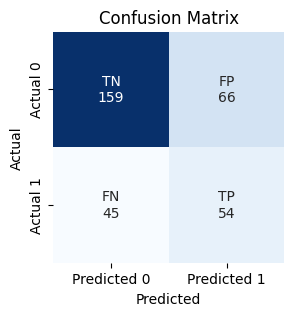

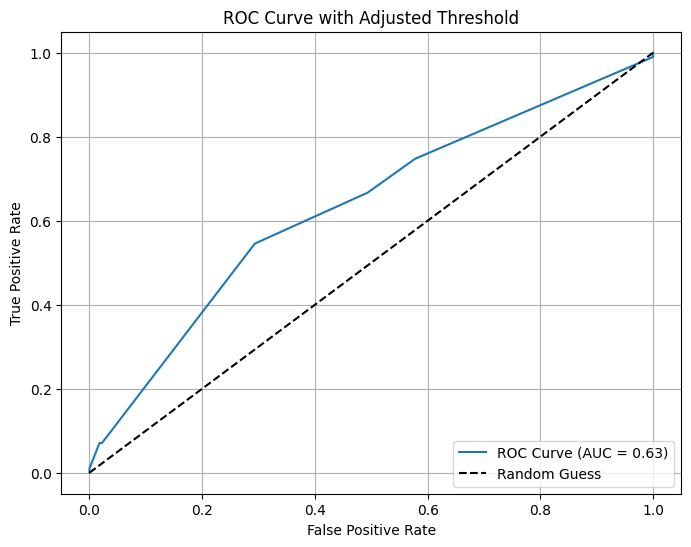

In [10]:
def evaluate_model_with_threshold(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    plot_confusion_matrix(y_true, y_pred)

# Get predicted probabilities on the test set using the existing model
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Apply the optimal threshold
y_test_pred = (y_test_proba >= best_threshold).astype(int)

print("\nModel Evaluation After Adjusting Threshold:")
evaluate_model_with_threshold(y_test, y_test_pred)


from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the ROC curve using the predicted probabilities
fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_proba)
auc_score = roc_auc_score(y_test, y_test_proba)

# Find the index of the threshold closest to the adjusted threshold
optimal_idx = np.argmin(np.abs(roc_thresholds - best_threshold))
optimal_fpr = fpr[optimal_idx]
optimal_tpr = tpr[optimal_idx]

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Mark the point corresponding to the adjusted threshold
# plt.scatter(optimal_fpr, optimal_tpr, color='red', s=100, label=f'Adjusted Threshold = {best_threshold:.2f}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Adjusted Threshold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Node Accuracy Calculation
Calculate the accuracy of each node in the decision tree to identify how well the model performs within each node.

In [11]:
# Function to calculate node accuracy
def calculate_node_accuracy(tree_model, X_train, y_train):
    leaf_ids = tree_model.apply(X_train)
    node_accuracies = {}
    for node_id in np.unique(leaf_ids):
        sample_ids = np.where(leaf_ids == node_id)[0]
        y_true = y_train.iloc[sample_ids]  
        y_pred = tree_model.predict(X_train.iloc[sample_ids]) 
        correct_predictions = np.sum(y_true == y_pred)
        total_samples = len(sample_ids)
        accuracy = correct_predictions / total_samples if total_samples > 0 else 0
        node_accuracies[node_id] = accuracy
    return node_accuracies

# Calculate node accuracy
node_accuracies = calculate_node_accuracy(best_model, X_train, y_train)

## Decision Tree Visualization

### Traning Set Visualization

Visualize the tree with node IDs and accuracies to better understand model decisions.


Initial Decision Tree Visualization with Node Accuracy:


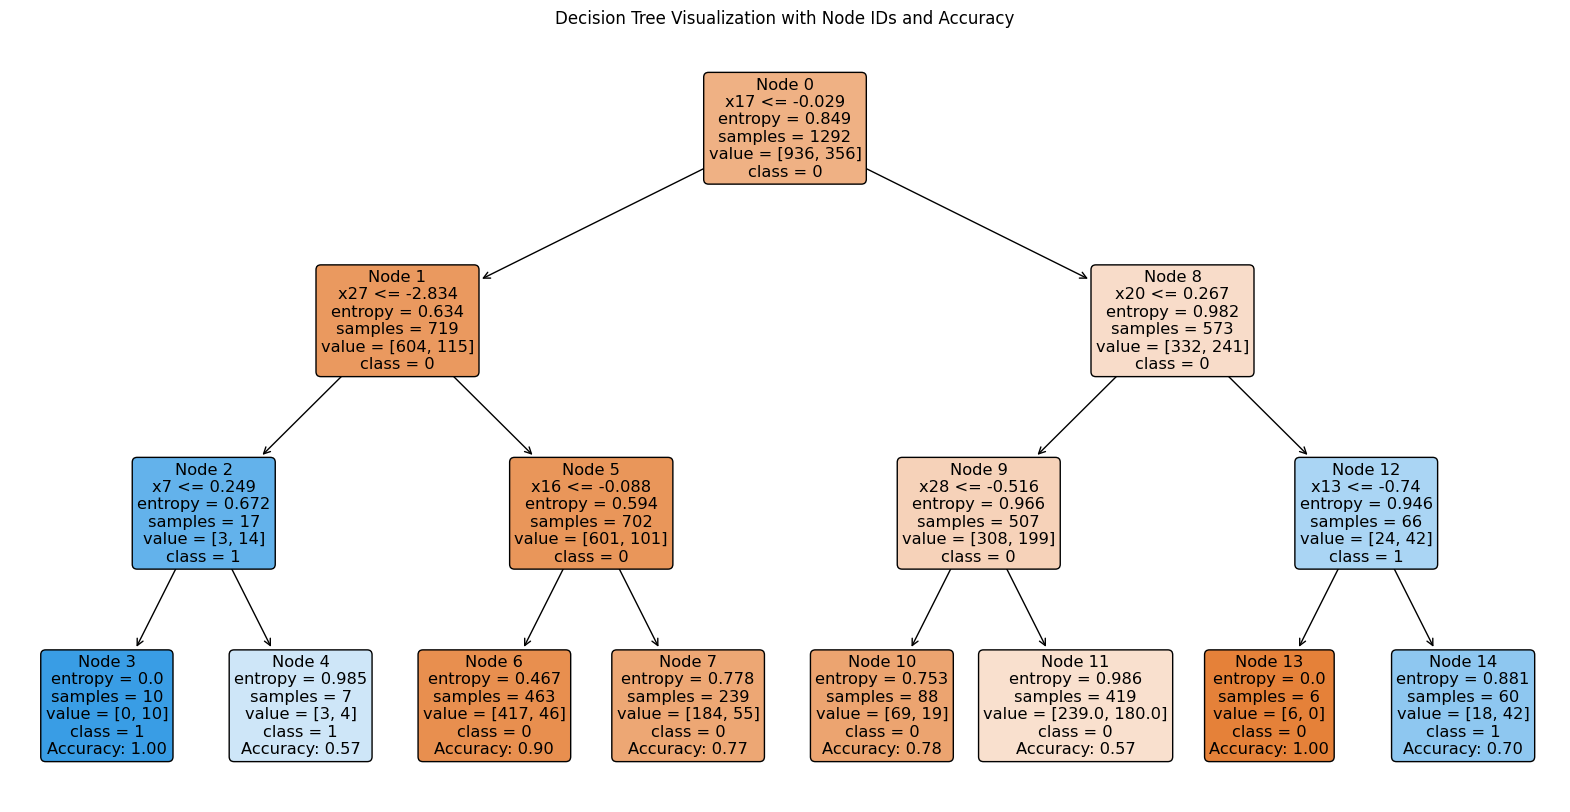

In [12]:
def visualize_tree_with_node_accuracy(tree_model, node_accuracies, feature_names):
    plt.figure(figsize=(20, 10))
    tree_plot = tree.plot_tree(tree_model, filled=True, feature_names=feature_names, class_names=["0", "1"], rounded=True)
    ax = plt.gca()
    for idx, text in enumerate(ax.texts):
        node_id = idx
        text.set_text(f"Node {node_id}\n" + text.get_text())
        if node_id in node_accuracies:
            node_accuracy = node_accuracies[node_id]
            updated_text = text.get_text() + f"\nAccuracy: {node_accuracy:.2f}"
            text.set_text(updated_text)
    plt.title("Decision Tree Visualization with Node IDs and Accuracy")
    plt.show()

print("\nInitial Decision Tree Visualization with Node Accuracy:")
num_features = X_train.shape[1]
feature_names = [f"x{index}" for index in range(num_features)]
visualize_tree_with_node_accuracy(best_model, node_accuracies, feature_names)

### Test Set Visualization

In this section, we visualize the decision tree with the test set data to observe how well the model performs on unseen data.

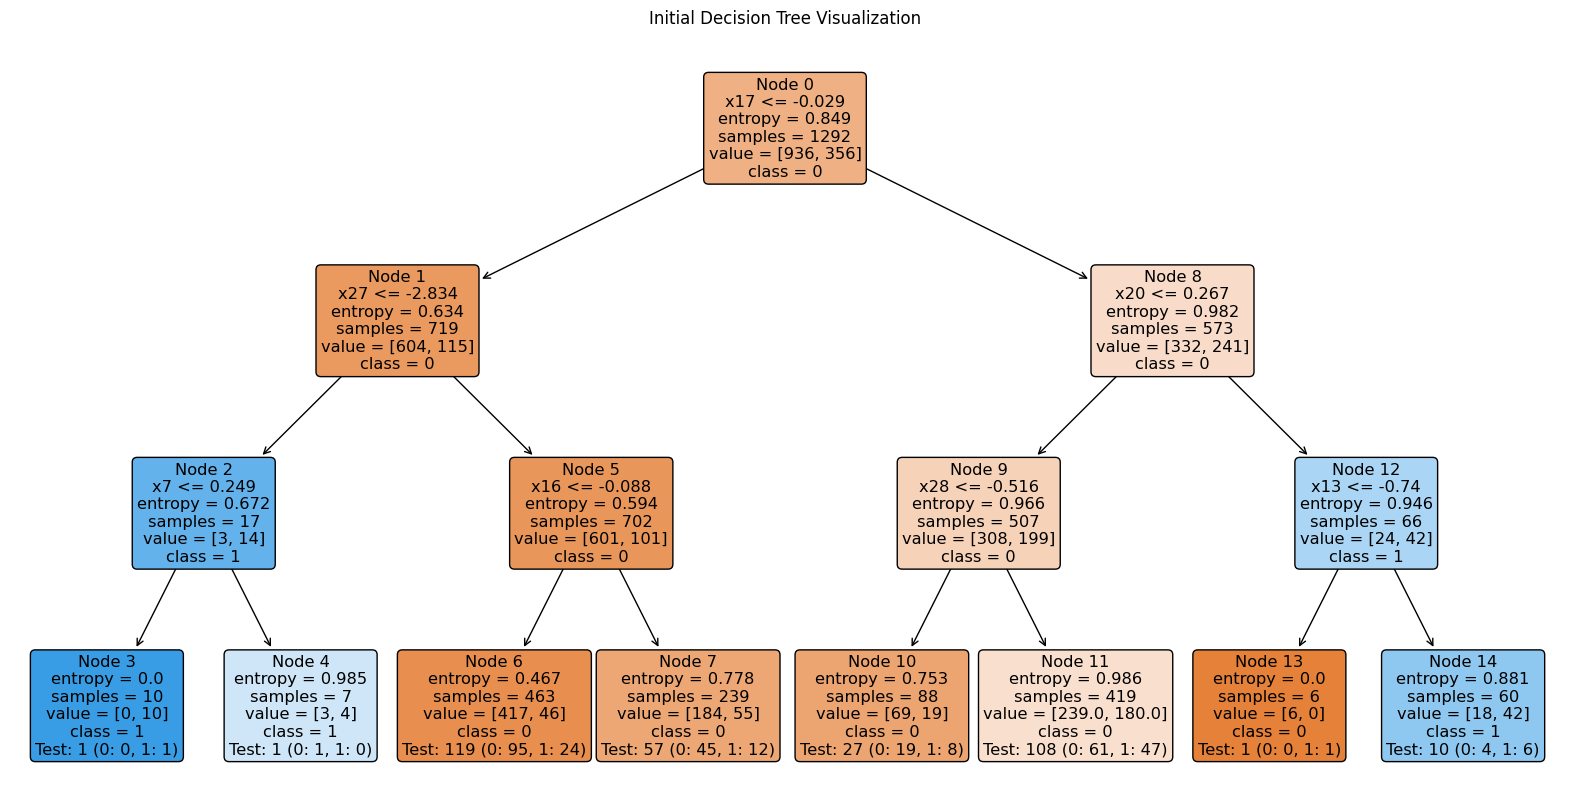

In [13]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

def annotate_tree_with_all_node_ids(tree_model, X_test, y_test, feature_names):
    # Apply the model to get the leaf nodes for each test instance
    leaf_ids = tree_model.apply(X_test)

    # Count the number of occurrences of each class in each leaf node
    leaf_counts = {}
    for leaf_id, label in zip(leaf_ids, y_test):
        if leaf_id not in leaf_counts:
            leaf_counts[leaf_id] = {'total': 0, 'class_0': 0, 'class_1': 0}
        leaf_counts[leaf_id]['total'] += 1
        if label == 0:
            leaf_counts[leaf_id]['class_0'] += 1
        else:
            leaf_counts[leaf_id]['class_1'] += 1

    # Visualize the tree
    plt.figure(figsize=(20, 10))
    tree_plot = plot_tree(tree_model, feature_names=feature_names, class_names=["0", "1"], filled=True, rounded=True)

    # Modify annotations to include node numbers and test data counts (if available)
    for i, text in enumerate(plt.gca().texts):
        text_parts = text.get_text().split('\n')
        text_parts.insert(0, f"Node {i}")  # Add node number at the beginning

        # If the node has test data, append test data info
        if i in leaf_counts:
            text_parts.append(f"Test: {leaf_counts[i]['total']} (0: {leaf_counts[i]['class_0']}, 1: {leaf_counts[i]['class_1']})")
        
        text.set_text('\n'.join(text_parts))

    plt.title("Initial Decision Tree Visualization")
    plt.show()

# Assuming 'best_model' is your trained DecisionTreeClassifier
num_features = X_test.shape[1]
feature_names = [f"x{index}" for index in range(num_features)]
annotate_tree_with_all_node_ids(best_model, X_test, y_test, feature_names)

## Feature Range Calculation for Nodes

To improve model's performance, we analyze the range of specific features for class 1 samples in selected nodes. This helps us understand feature distributions that could affect model performance.

Currently, we focus on node 14 and node 6. Our goal is to generate augmented data for node 14, using features that define the path to this node (x17, x20, x13). 

To make the new samples more effective, we calculate the ranges of these features and avoid overlapping with node 6’s feature ranges. Node 6’s accuracy for class 0 is nearly 90%, indicating a strong confidence in class 0 predictions. By avoiding these feature ranges, we aim to create robust samples that enhance overall model performance.

{14: {17: (-0.015024695915693194, 1.5008177388689259), 20: (0.2693023348517156, 1.1609997617752696), 13: (-0.7375557569336142, 2.7820454420116563)}, 6: {17: (-1.937852498208124, -0.08883008169495517), 20: (-0.48205408544416, 0.7768915431378955), 13: (-1.5793918717246624, 2.8675280393110243)}}


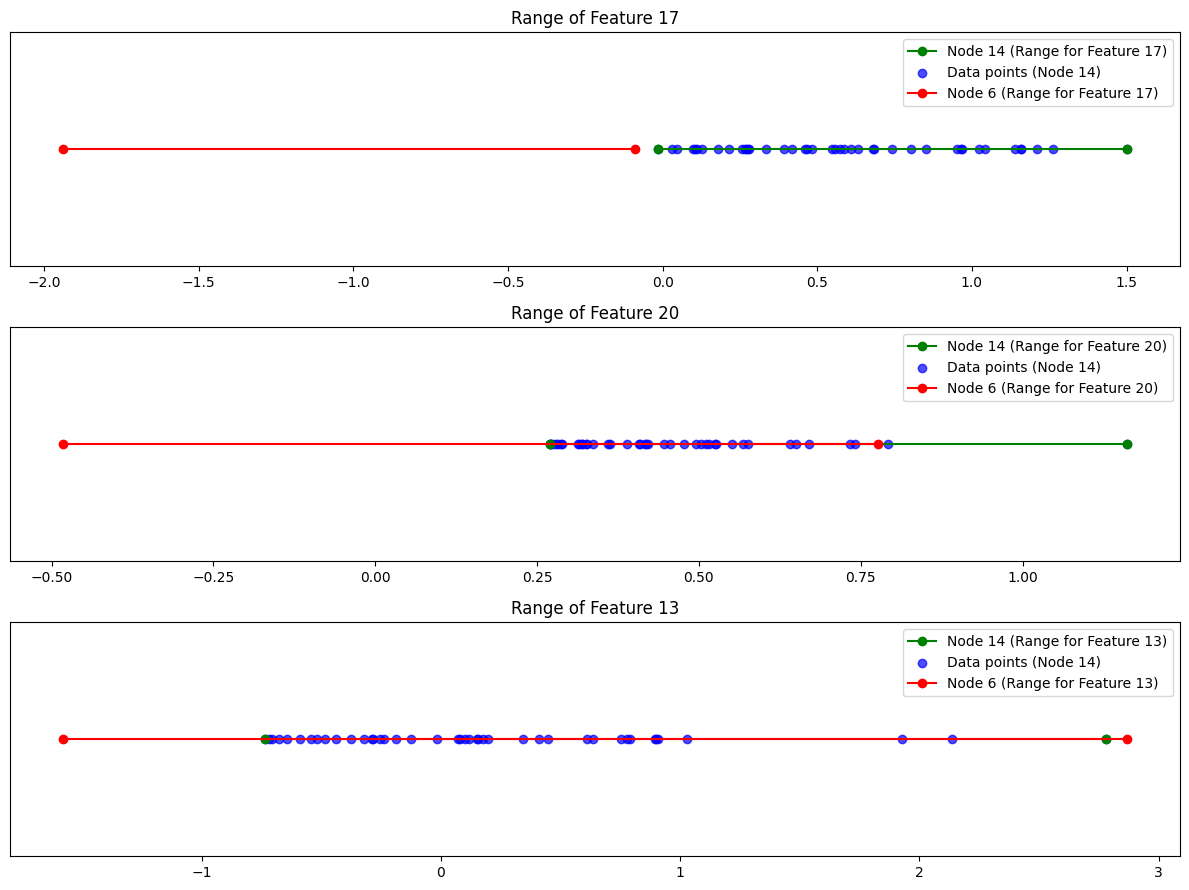

In [13]:
import matplotlib.pyplot as plt

def calculate_feature_ranges(tree_model, X_train, y_train, target_node_id, avoid_node_id, features):
    ranges = {}
    node_samples = {}
    
    for node_id in [target_node_id, avoid_node_id]:
        leaf_ids = tree_model.apply(X_train)  # Get the leaf node assignments for each sample
        samples_in_node = X_train.iloc[leaf_ids == node_id]  # Get samples for the current node
        class_1_samples = samples_in_node[y_train.iloc[leaf_ids == node_id] == 1]  # Filter class 1 samples
        
        # Initialize an empty dict to store ranges for the current node
        ranges[node_id] = {}
        
        # Iterate over the features to calculate ranges
        for feature in features:
            # Get the min and max values for the current feature
            min_value = class_1_samples.iloc[:, feature].min()
            max_value = class_1_samples.iloc[:, feature].max()
            
            # Store the range for the current node and feature
            ranges[node_id][feature] = (min_value, max_value)
        
        # Store the class 1 samples for future use
        node_samples[node_id] = class_1_samples
    
    return ranges, node_samples

def plot_feature_ranges(ranges, features, node_samples, target_node_id, range_colors=["green", "red"], point_color="blue"):
    fig, axs = plt.subplots(len(features), 1, figsize=(12, len(features) * 3))
    
    for i, feature in enumerate(features):
        for j, (node_id, node_ranges) in enumerate(ranges.items()):
            feature_range = node_ranges[feature]
            # Plot the feature range for each node
            axs[i].plot(feature_range, [i]*2, marker='o', color=range_colors[j], label=f"Node {node_id} (Range for Feature {feature})")
            axs[i].set_title(f"Range of Feature {feature}")
            
            # Only plot the actual data points for the target node
            if node_id == target_node_id:
                data_points = node_samples[node_id].iloc[:, feature]  # Extract the data points for this feature
                axs[i].scatter(data_points, [i]*len(data_points), color=point_color, alpha=0.7, label=f"Data points (Node {node_id})")
    
    for ax in axs:
        ax.legend()
        ax.set_yticks([]) 

    plt.tight_layout()
    plt.show()

# Define everything outside the functions
target_node_id = 14 
avoid_node_id = 6   
features_of_interest = [17, 20, 13]  

# target_node_id = 3 
# avoid_node_id = 10  
# features_of_interest = [17, 27, 7]  

# Calculate the feature ranges and get the data points for each node
ranges, node_samples = calculate_feature_ranges(best_model, X_train, y_train, target_node_id, avoid_node_id, features_of_interest)

print(ranges)

# Plot feature ranges along with data points only for the target node
plot_feature_ranges(ranges, features_of_interest, node_samples, target_node_id)

## Generating New Samples
Generate new samples that avoid specific feature ranges identified in a previous analysis.

We are generating same amount of class 1 samples in node 14.

In [14]:
import numpy as np
import pandas as pd

# Function to determine if we can avoid the range
def can_avoid_range(valid_range, avoid_range):
    return not (valid_range[0] >= avoid_range[0] and valid_range[1] <= avoid_range[1])

# Function to sample within a range while avoiding a specific range
def sample_avoiding_range(valid_range, avoid_range):
    while True:
        value = np.random.uniform(valid_range[0], valid_range[1])
        if not (avoid_range[0] <= value <= avoid_range[1]):
            return value

# Function to identify features with valid ranges
def identify_valid_ranges(target_ranges, avoid_ranges):
    valid_features = {}
    for feature, valid_range in target_ranges.items():
        avoid_range = avoid_ranges.get(feature, None)
        
        if avoid_range is not None:
            # Check if the feature has a valid range
            if can_avoid_range(valid_range, avoid_range):
                valid_features[feature] = valid_range
            else:
                print(f"Skipping feature {feature} as no valid range is available.")
        else:
            # No avoid range is available; this feature is valid
            valid_features[feature] = valid_range
            print(f"No avoid_range available for feature {feature}.")

    return valid_features

# Function to generate samples using valid ranges from the target node
def generate_avoiding_samples(target_data, valid_ranges, avoid_ranges, num_samples, seed):
    np.random.seed(seed)
    generated_samples = []
    
    for _ in range(num_samples):
        sample = {}
        
        # Generate new samples based on valid ranges
        for feature, valid_range in valid_ranges.items():
            avoid_range = avoid_ranges.get(feature, None)
            
            # Attempt to generate a sample for this feature
            if avoid_range is not None:
                sample_value = sample_avoiding_range(valid_range, avoid_range)
            else:
                # If no avoid range, just sample within the valid range
                sample_value = np.random.uniform(valid_range[0], valid_range[1])
            
            sample[feature] = sample_value
        
        # Fill in the rest of the features, excluding those in valid_ranges
        features_to_drop = list(valid_ranges.keys())
        other_features = target_data.drop(columns=features_to_drop).sample(n=1, replace=True).iloc[0].to_dict()
        sample.update(other_features)
        
        generated_samples.append(sample)
    
    # Convert the list of samples into a DataFrame
    generated_samples_df = pd.DataFrame(generated_samples)
    
    # Ensure the column order matches the original data
    desired_order = target_data.columns.tolist()
    generated_samples_df = generated_samples_df[desired_order]
    generated_samples_df['label'] = 1  # Assign label 1 for class 1 samples

    return generated_samples_df

# Define parameters outside the functions
target_data = X_train[(best_model.apply(X_train) == target_node_id) & (y_train == 1)]  # Extract data for the target node

# Get the feature ranges for the target and avoid nodes
target_ranges = ranges.get(target_node_id, {})
avoid_ranges = ranges.get(avoid_node_id, {})

# Identify features with valid ranges for the target node, avoiding ranges from the avoid node
valid_ranges = identify_valid_ranges(target_ranges, avoid_ranges)

# Number of samples to generate (same as the number of class 1 samples in the target node)
num_class_1_samples_target = len(target_data)

# Generate samples using valid ranges
generated_samples = generate_avoiding_samples(target_data, valid_ranges, avoid_ranges, num_samples=int(len(y_train[y_train == 1]) * 0.1), seed=42)

print(f"\nNumber of generated samples: {len(generated_samples)}")

# Displaying the generated samples to confirm correctness
# print("\nGenerated Samples:")
# print(generated_samples)

Skipping feature 13 as no valid range is available.

Number of generated samples: 35


## Merging New Samples with the Training Set

In this section, we will merge the newly generated samples with the existing training set.

In [15]:
def merge_with_training_data(X_train, y_train, generated_samples):
    X_train_augmented = pd.concat([X_train, generated_samples.drop(columns=['label'])], ignore_index=True)
    y_train_augmented = pd.concat([y_train, generated_samples['label']], ignore_index=True)
    return X_train_augmented, y_train_augmented

X_train_augmented, y_train_augmented = merge_with_training_data(X_train, y_train, generated_samples)

# Print the new size of the training set
print(f"\nTraining data size after adding new samples: {X_train_augmented.shape}")
print(f"Label size after adding new samples: {y_train_augmented.shape}")

# Print the distribution of labels in the augmented training set
print("\nLabel distribution in the augmented training set:")
print(y_train_augmented.value_counts(normalize=True))


Training data size after adding new samples: (1327, 37)
Label size after adding new samples: (1327,)

Label distribution in the augmented training set:
label
0    0.70535
1    0.29465
Name: proportion, dtype: float64


## Performance Comparison of Initial and Augmented Decision Tree Models
In this section, we start by visualizing the initial decision tree with node accuracy annotations. We then augment the training data with newly generated samples and retrain the decision tree using the best hyperparameters obtained from grid search. 

Finally, we visualize the retrained tree and evaluate its performance on the test set to observe any improvements.

### Section 1: Plot the Initial Decision Tree and Augmented Decision Tree


Initial Decision Tree Visualization with Node Accuracy:


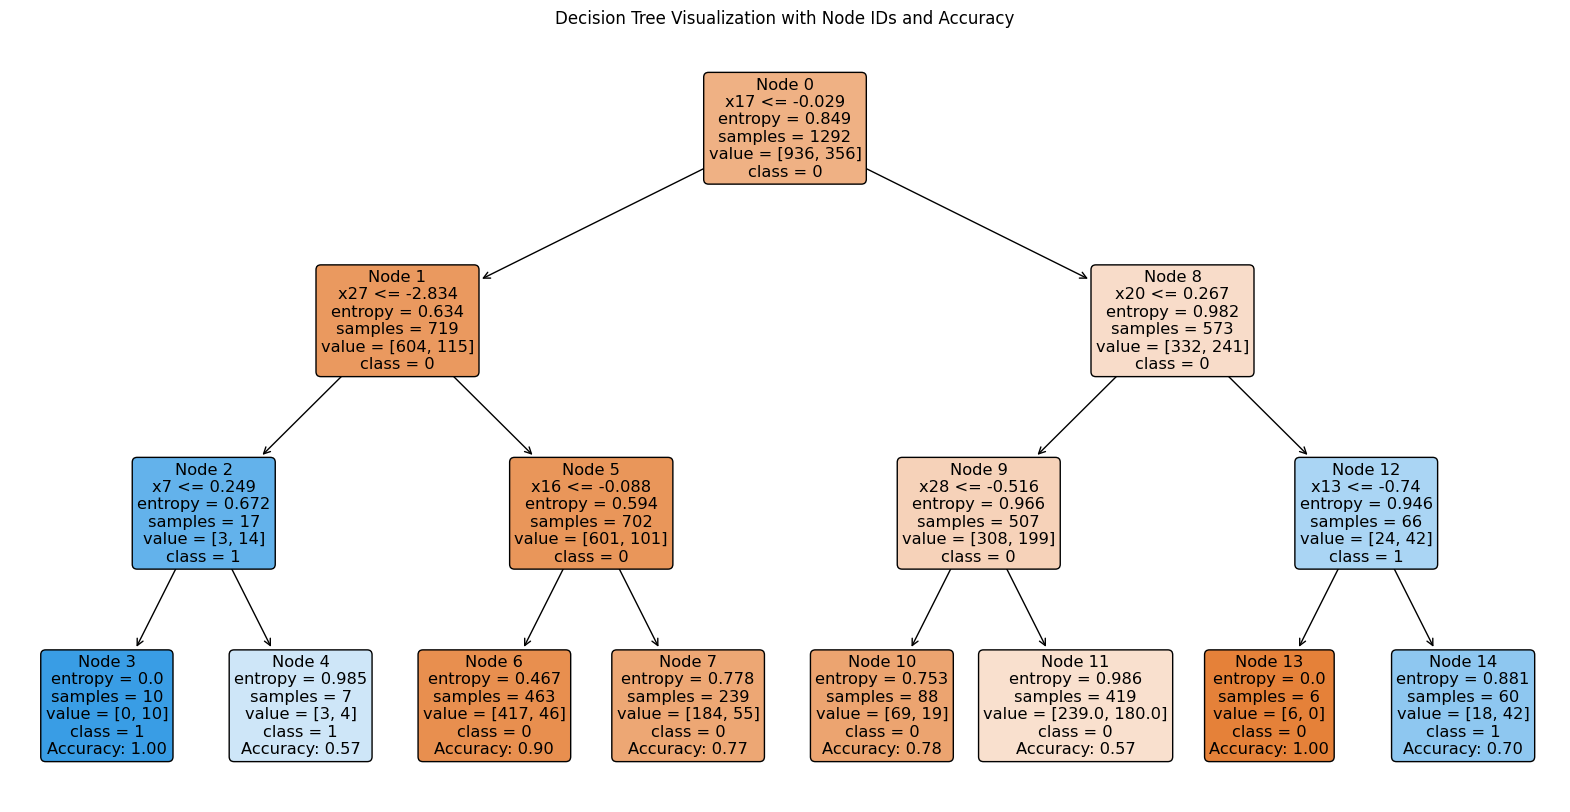


Merging New Samples with the Original Training Set:
Best Parameters for Retrained Model: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}

Visualization of Retrained Decision Tree with Node Accuracy:


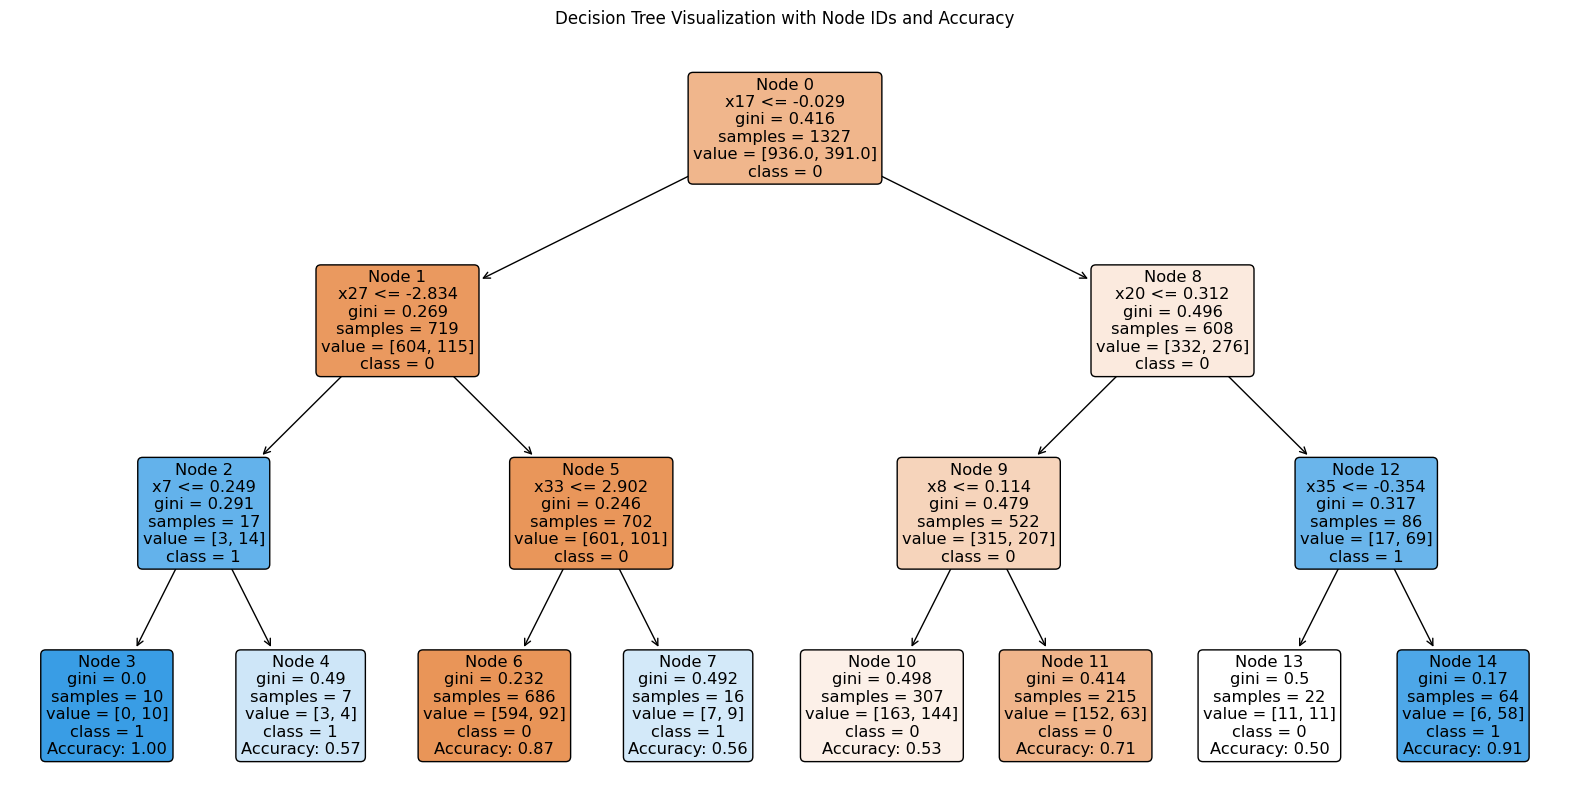

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the initial decision tree with node accuracy
print("\nInitial Decision Tree Visualization with Node Accuracy:")
num_features = X_train.shape[1]
feature_names = [f"x{index}" for index in range(num_features)]
visualize_tree_with_node_accuracy(best_model, node_accuracies, feature_names)

# --- Merging New Samples with the Original Training Set ---
print("\nMerging New Samples with the Original Training Set:")

# Perform grid search on the augmented training data
grid_search_augmented = perform_grid_search(X_train_augmented, y_train_augmented)
print(f"Best Parameters for Retrained Model: {grid_search_augmented.best_params_}")

# Retrain the model with the best parameters from grid search
best_retrained_model = train_best_model(grid_search_augmented, X_train_augmented, y_train_augmented)

# Calculate node accuracy for the retrained model
node_accuracies_retrained = calculate_node_accuracy(best_retrained_model, X_train_augmented, y_train_augmented)

# Plot the retrained decision tree with node accuracy
print("\nVisualization of Retrained Decision Tree with Node Accuracy:")
visualize_tree_with_node_accuracy(best_retrained_model, node_accuracies_retrained, feature_names)

### Compare the Results of Initial and Augmented Models


Evaluating the Initial Model on the Test Set with Adjusted Threshold:
Evaluation Metrics at Threshold 0.26:
Accuracy: 0.66
Precision: 0.45
Recall: 0.55
F1-Score: 0.49
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74       225
           1       0.45      0.55      0.49        99

    accuracy                           0.66       324
   macro avg       0.61      0.63      0.62       324
weighted avg       0.68      0.66      0.67       324



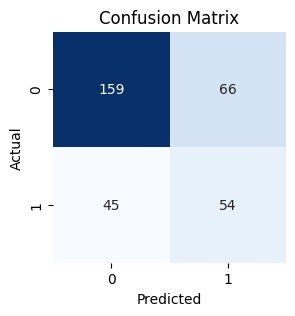


Evaluating the Retrained Model on the Test Set with Adjusted Threshold:
Evaluation Metrics at Threshold 0.26:
Accuracy: 0.63
Precision: 0.43
Recall: 0.65
F1-Score: 0.51
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.62      0.70       225
           1       0.43      0.65      0.51        99

    accuracy                           0.63       324
   macro avg       0.61      0.63      0.61       324
weighted avg       0.69      0.63      0.64       324



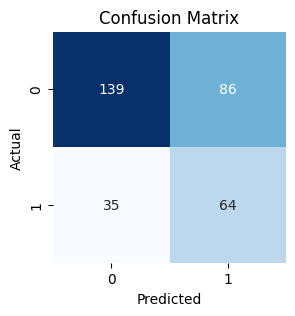

In [17]:
def evaluate_model_with_threshold(model, X_test, y_test, threshold):
    # Predict probabilities for the positive class
    y_proba = model.predict_proba(X_test)[:, 1]

    # Apply the custom threshold to get class predictions
    y_pred = (y_proba >= threshold).astype(int)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Print results
    print(f"Evaluation Metrics at Threshold {threshold:.2f}:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False, xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# --- Initial Model Evaluation ---
print("\nEvaluating the Initial Model on the Test Set with Adjusted Threshold:")
evaluate_model_with_threshold(best_model, X_test, y_test, best_threshold)

# --- Augmented Model Evaluation ---
print("\nEvaluating the Retrained Model on the Test Set with Adjusted Threshold:")
evaluate_model_with_threshold(best_retrained_model, X_test, y_test, best_threshold)

### Passing the Test set through the Retrained Tree

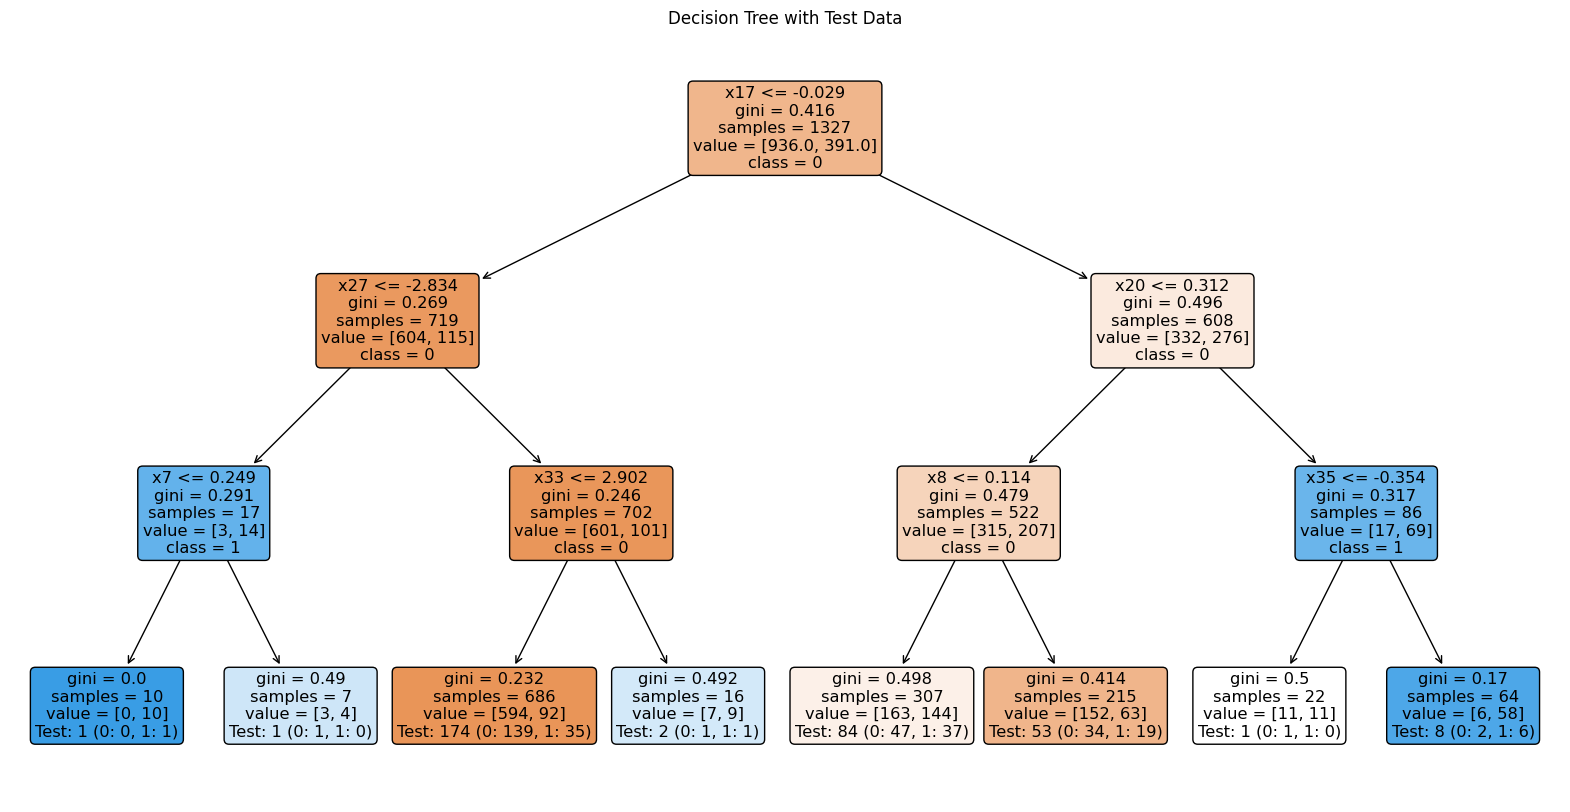

In [18]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

def annotate_tree_with_test_data(tree_model, X_test, y_test, feature_names):
    # Apply the model to get the leaf nodes for each test instance
    leaf_ids = tree_model.apply(X_test)

    # Count the number of occurrences of each class in each leaf node
    leaf_counts = {}
    for leaf_id, label in zip(leaf_ids, y_test):
        if leaf_id not in leaf_counts:
            leaf_counts[leaf_id] = {'total': 0, 'class_0': 0, 'class_1': 0}
        leaf_counts[leaf_id]['total'] += 1
        if label == 0:
            leaf_counts[leaf_id]['class_0'] += 1
        else:
            leaf_counts[leaf_id]['class_1'] += 1

    # Visualize the tree
    plt.figure(figsize=(20, 10))
    tree_plot = plot_tree(tree_model, feature_names=feature_names, class_names=["0", "1"], filled=True, rounded=True)

    # Modify annotations to include test data information
    for i, text in enumerate(plt.gca().texts):
        # Node id is assumed to be the i-th node
        if i in leaf_counts:
            text_parts = text.get_text().split('\n')
            text_parts[-1] = f"Test: {leaf_counts[i]['total']} (0: {leaf_counts[i]['class_0']}, 1: {leaf_counts[i]['class_1']})"
            text.set_text('\n'.join(text_parts))

    plt.title("Decision Tree with Test Data")
    plt.show()

# Assuming 'best_model' is your trained DecisionTreeClassifier
num_features = X_test.shape[1]
feature_names = [f"x{index}" for index in range(num_features)]
annotate_tree_with_test_data(best_retrained_model, X_test, y_test, feature_names)

## False Positives and False Negatives Analysis

This section explores how augmenting the training data by generating synthetic samples affects the model's performance, specifically focusing on False Negatives (FN) and False Positives (FP). We generate augmented data equivalent to 10%, 20%, 50%, and 100% of the original training data, retrain the model, and evaluate FN and FP for each case.


### FN and FP analysis for traning data


Generating 10.0% of class 1 data (35 samples)...
Accuracy: 0.66

Generating 20.0% of class 1 data (71 samples)...
Accuracy: 0.66

Generating 50.0% of class 1 data (178 samples)...
Accuracy: 0.66

Generating 100.0% of class 1 data (356 samples)...
Accuracy: 0.66


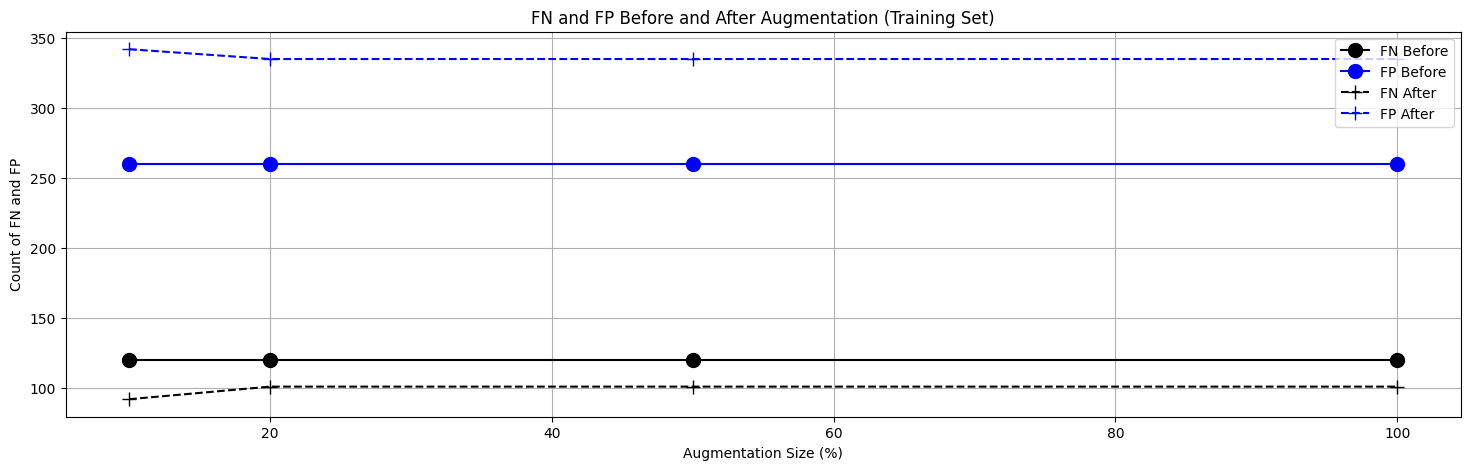

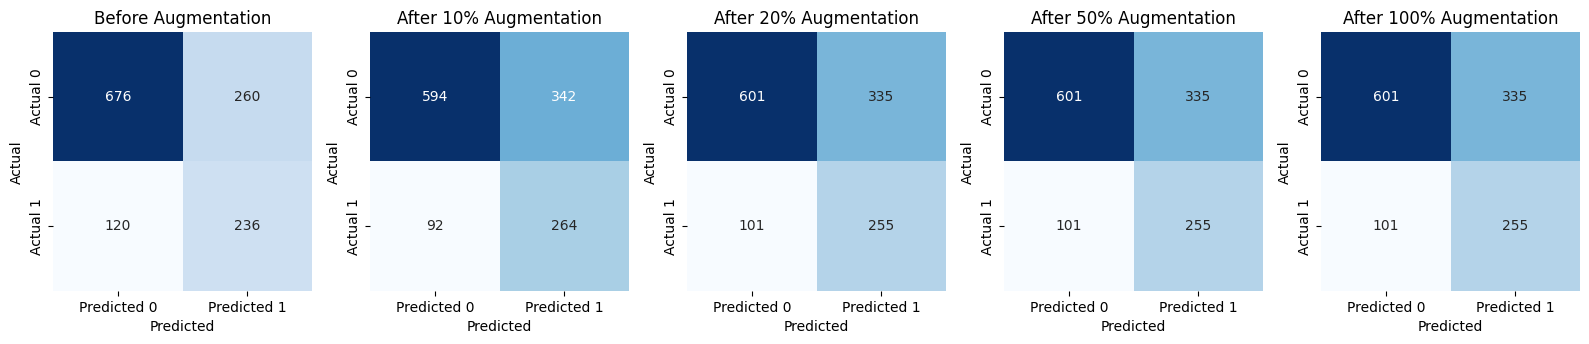

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrices side by side
def plot_confusion_matrices_side_by_side(confusion_matrices, titles, nrows, ncols):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))
    axes = axes.flatten()

    for i, (cm, title) in enumerate(zip(confusion_matrices, titles)):
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False, square=True, 
                    xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"],
                    ax=axes[i])
        axes[i].set_title(title)
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

# Function to retrain the model and evaluate FP and FN using the best_threshold on the training set
def retrain_and_evaluate_on_train(X_train_augmented, y_train_augmented, X_train, y_train, best_threshold):
    grid_search_augmented = perform_grid_search(X_train_augmented, y_train_augmented)
    
    best_retrained_model = train_best_model(grid_search_augmented, X_train_augmented, y_train_augmented)
    
    y_train_proba = best_retrained_model.predict_proba(X_train)[:, 1]

    y_train_pred = (y_train_proba >= best_threshold).astype(int)

    cm = confusion_matrix(y_train, y_train_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    print(f"Accuracy: {accuracy:.2f}")
    
    return fn, fp, cm

# Function to evaluate FN and FP before augmentation on the training set
def evaluate_before_augmentation(X_train, y_train, best_model, best_threshold):
    y_train_proba = best_model.predict_proba(X_train)[:, 1]
    
    y_train_pred = (y_train_proba >= best_threshold).astype(int)
    
    cm = confusion_matrix(y_train, y_train_pred)
    tn, fp, fn, tp = cm.ravel()
    
    return fn, fp, cm

# Function to merge generated samples with the original training data
def merge_with_training_data(X_train, y_train, generated_samples):
    X_generated = generated_samples.drop(columns=['label'])
    y_generated = generated_samples['label']

    X_train_augmented = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_augmented = pd.concat([y_train, y_generated], ignore_index=True)
    
    return X_train_augmented, y_train_augmented

# Function to augment data, retrain the model, and evaluate FN and FP for different percentages on the training set
def augment_and_evaluate_on_train(X_train, y_train, target_data, valid_ranges, avoid_ranges, percentages, best_model, best_threshold):
    fn_after_list = []
    fp_after_list = []
    confusion_matrices_after = []
    np.random.seed(42)  

    num_class_1_samples = len(y_train[y_train == 1])
    
    fn_before, fp_before, cm_before = evaluate_before_augmentation(X_train, y_train, best_model, best_threshold)
    
    for percentage in percentages:
        num_samples_to_generate = int(num_class_1_samples * percentage)
        print(f"\nGenerating {percentage * 100}% of class 1 data ({num_samples_to_generate} samples)...")
        
        generated_samples = generate_avoiding_samples(target_data, valid_ranges, avoid_ranges, num_samples_to_generate, seed=42)
        
        X_train_augmented, y_train_augmented = merge_with_training_data(X_train, y_train, generated_samples)
        
        fn_after, fp_after, cm_after = retrain_and_evaluate_on_train(X_train_augmented, y_train_augmented, X_train, y_train, best_threshold)
        fn_after_list.append(fn_after)
        fp_after_list.append(fp_after)
        confusion_matrices_after.append(cm_after)
    
    return fn_before, fp_before, fn_after_list, fp_after_list, cm_before, confusion_matrices_after

percentages = [0.1, 0.2, 0.5, 1.0]  # Percentages of class 1 data to generate

# Evaluate for different percentages of augmentation on the training set
fn_before, fp_before, fn_after_list, fp_after_list, cm_before, confusion_matrices_after = augment_and_evaluate_on_train(
    X_train, y_train, target_data, valid_ranges, avoid_ranges, percentages, best_model, best_threshold
)

# Prepare the results dataframe with the data from your experiment
results_df = pd.DataFrame({
    'FN Before': [fn_before] * len(percentages),  
    'FP Before': [fp_before] * len(percentages), 
    'FN After': fn_after_list,  
    'FP After': fp_after_list 
})

# Function to create the plot for FN and FP
def plot_fn_fp_augmentation(results_df, percentages):
    plt.figure(figsize=(18, 5))

    plt.plot([int(p * 100) for p in percentages], results_df['FN Before'], 'ko-', label='FN Before', markersize=10)

    plt.plot([int(p * 100) for p in percentages], results_df['FP Before'], 'bo-', label='FP Before', markersize=10)

    plt.plot([int(p * 100) for p in percentages], results_df['FN After'], 'k+--', label='FN After', markersize=10)

    plt.plot([int(p * 100) for p in percentages], results_df['FP After'], 'b+--', label='FP After', markersize=10)

    plt.xlabel('Augmentation Size (%)')
    plt.ylabel('Count of FN and FP')
    plt.title('FN and FP Before and After Augmentation (Training Set)')
    plt.legend(loc='upper right')

    plt.grid(True)
    plt.show()

plot_fn_fp_augmentation(results_df, percentages)

all_confusion_matrices = [cm_before] + confusion_matrices_after
titles = ['Before Augmentation'] + [f'After {int(p*100)}% Augmentation' for p in percentages]
plot_confusion_matrices_side_by_side(all_confusion_matrices, titles, nrows=1, ncols=5)

### FN and FP analysis for test data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrices side by side
def plot_confusion_matrices_side_by_side(confusion_matrices, titles, nrows, ncols):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))
    axes = axes.flatten()

    for i, (cm, title) in enumerate(zip(confusion_matrices, titles)):
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False, square=True, 
                    xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"],
                    ax=axes[i])
        axes[i].set_title(title)
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

# Function to retrain the model and evaluate FP and FN using the best_threshold on the test set
def retrain_and_evaluate_on_test(X_train_augmented, y_train_augmented, X_test, y_test, best_threshold):
    # Perform grid search on the augmented training data
    grid_search_augmented = perform_grid_search(X_train_augmented, y_train_augmented)
    
    # Retrain the model with the best parameters from grid search
    best_retrained_model = train_best_model(grid_search_augmented, X_train_augmented, y_train_augmented)
    
    # Get predicted probabilities on the test set
    y_test_proba = best_retrained_model.predict_proba(X_test)[:, 1]

    # Apply the best threshold
    y_test_pred = (y_test_proba >= best_threshold).astype(int)

    # Get confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    print(f"Accuracy: {accuracy:.2f}")
    
    return fn, fp, cm

# Function to evaluate FN and FP before augmentation on the test set
def evaluate_before_augmentation(X_test, y_test, best_model, best_threshold):
    # Get predicted probabilities on the test set
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Apply the best threshold
    y_test_pred = (y_test_proba >= best_threshold).astype(int)
    
    # Get confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm.ravel()
    
    return fn, fp, cm

# Function to merge generated samples with the original training data
def merge_with_training_data(X_train, y_train, generated_samples):
    # Extract features and labels from the generated samples
    X_generated = generated_samples.drop(columns=['label'])
    y_generated = generated_samples['label']

    # Concatenate the original training data with the generated data
    X_train_augmented = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_augmented = pd.concat([y_train, y_generated], ignore_index=True)
    
    return X_train_augmented, y_train_augmented

# Function to augment data, retrain the model, and evaluate FN and FP for different percentages on the test set
def augment_and_evaluate_on_test(X_train, y_train, X_test, y_test, target_data, valid_ranges, avoid_ranges, percentages, best_model, best_threshold):
    fn_after_list = []
    fp_after_list = []
    confusion_matrices_after = []
    np.random.seed(42)  # Ensuring consistent random seed for reproducibility

    # Get the number of class 1 samples in the training set
    num_class_1_samples = len(y_train[y_train == 1])
    
    # Evaluate FN and FP before augmentation
    fn_before, fp_before, cm_before = evaluate_before_augmentation(X_test, y_test, best_model, best_threshold)
    
    for percentage in percentages:
        num_samples_to_generate = int(num_class_1_samples * percentage)
        print(f"\nGenerating {percentage * 100}% of class 1 data ({num_samples_to_generate} samples)...")
        
        # Generate augmented data
        generated_samples = generate_avoiding_samples(target_data, valid_ranges, avoid_ranges, num_samples_to_generate, seed=42)
        
        # Merge with training data
        X_train_augmented, y_train_augmented = merge_with_training_data(X_train, y_train, generated_samples)
        
        # Retrain and evaluate the model on the test set
        fn_after, fp_after, cm_after = retrain_and_evaluate_on_test(X_train_augmented, y_train_augmented, X_test, y_test, best_threshold)
        fn_after_list.append(fn_after)
        fp_after_list.append(fp_after)
        confusion_matrices_after.append(cm_after)
    
    return fn_before, fp_before, fn_after_list, fp_after_list, cm_before, confusion_matrices_after

# Define percentages to evaluate
percentages = [0.1, 0.2, 0.5, 1.0]  # Percentages of class 1 data to generate

# Evaluate for different percentages of augmentation on the test set
fn_before, fp_before, fn_after_list, fp_after_list, cm_before, confusion_matrices_after = augment_and_evaluate_on_test(
    X_train, y_train, X_test, y_test, target_data, valid_ranges, avoid_ranges, percentages, best_model, best_threshold
)

# Prepare the results dataframe with the data from your experiment
results_df = pd.DataFrame({
    'FN Before': [fn_before] * len(percentages),  # FN before is constant for all percentages
    'FP Before': [fp_before] * len(percentages),  # FP before is constant for all percentages
    'FN After': fn_after_list,  # FN after augmentation for each percentage
    'FP After': fp_after_list   # FP after augmentation for each percentage
})

# Function to create the plot for FN and FP
def plot_fn_fp_augmentation(results_df, percentages):
    plt.figure(figsize=(18, 5))

    # Plot FN before augmentation
    plt.plot([int(p * 100) for p in percentages], results_df['FN Before'], 'ko-', label='FN Before', markersize=10)

    # Plot FP before augmentation
    plt.plot([int(p * 100) for p in percentages], results_df['FP Before'], 'bo-', label='FP Before', markersize=10)

    # Plot FN after augmentation
    plt.plot([int(p * 100) for p in percentages], results_df['FN After'], 'k+--', label='FN After', markersize=10)

    # Plot FP after augmentation
    plt.plot([int(p * 100) for p in percentages], results_df['FP After'], 'b+--', label='FP After', markersize=10)

    # Add labels and title
    plt.xlabel('Augmentation Size (%)')
    plt.ylabel('Count of FN and FP')
    plt.title('FN and FP Before and After Augmentation (Test Set)')
    plt.legend(loc='upper right')

    # Show the plot
    plt.grid(True)
    plt.show()

# Plot FN and FP for different augmentation sizes
plot_fn_fp_augmentation(results_df, percentages)

# Plot confusion matrices: 1 before and 4 after augmentation
all_confusion_matrices = [cm_before] + confusion_matrices_after
titles = ['Before Augmentation'] + [f'After {int(p*100)}% Augmentation' for p in percentages]
plot_confusion_matrices_side_by_side(all_confusion_matrices, titles, nrows=1, ncols=5)

## Generating Augmented Data using Different Seeds

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import openpyxl
from sklearn.tree import plot_tree

def extract_specific_node_info(tree_model, nodes):
    tree_ = tree_model.tree_
    feature = tree_.feature
    threshold = tree_.threshold
    gini = tree_.impurity
    samples = tree_.n_node_samples
    values = tree_.value
    node_info = {}

    for node in nodes:
        feature_name = f"x{feature[node]}" if feature[node] != -2 else "Leaf"
        threshold_value = f"<= {threshold[node]:.4f}" if feature[node] != -2 else ""
        value_counts = (values[node][0] * samples[node]).astype(int).tolist()

        # Format information for each node
        formatted_info = (
            f"{feature_name} {threshold_value}\n"
            f"gini = {gini[node]:.4f}\n"
            f"samples: {samples[node]}\n"
            f"Value: {value_counts}"
        )
        node_info[f"Node {node}"] = formatted_info
        
    return node_info

# Function to save paths of multiple trees to Excel for specific nodes with a set max column width
def export_paths_to_excel(trees, nodes, seeds, file_name="specific_nodes_paths.xlsx"):
    all_paths = []

    for idx, (tree_model, seed) in enumerate(zip(trees, seeds)):
        print(f"Processing Tree {idx + 1} (Seed {seed})", flush=True)
        node_info = extract_specific_node_info(tree_model, nodes)
        
        row = [f"Seed {seed}"]
        for node in nodes:
            info = node_info[f"Node {node}"]
            row.append(info)
        
        all_paths.append(row)
    
    columns = ["Seed"] + [f"Node {node}" for node in nodes]
    df_paths = pd.DataFrame(all_paths, columns=columns)
    df_paths.to_excel(file_name, index=False)
    
    # Adjust column widths and enable text wrapping
    wb = openpyxl.load_workbook(file_name)
    ws = wb.active
    max_width = 10  # Set maximum width to prevent over-expansion
    for col in ws.columns:
        max_length = min(max(len(str(cell.value)) for cell in col), max_width)  # Limit width
        column_letter = col[0].column_letter
        ws.column_dimensions[column_letter].width = max_length + 5  # Add some space

    for row in ws.iter_rows():
        for cell in row:
            cell.alignment = openpyxl.styles.Alignment(wrap_text=True, horizontal="center", vertical="center")  # Enable wrap text

    wb.save(file_name)
    print(f"Specific node information saved to {file_name} with adjusted column widths and limited expansion.", flush=True)

# Function to plot individual decision trees with node numbers

def visualize_tree_with_node_info(tree_model, feature_names, title):
    plt.figure(figsize=(20, 10))
    tree_plot = plot_tree(tree_model, filled=True, feature_names=feature_names, class_names=["0", "1"], rounded=True)
    ax = plt.gca()
    
    for idx, text in enumerate(ax.texts):
        text.set_text(f"Node {idx}\n" + text.get_text())
        
    plt.title(title)
    plt.show()

def calculate_feature_ranges(tree_model, X_train, y_train, target_node_id, avoid_node_id, features):
    ranges = {}
    node_samples = {}
    
    for node_id in [target_node_id, avoid_node_id]:
        leaf_ids = tree_model.apply(X_train) 
        samples_in_node = X_train.iloc[leaf_ids == node_id]  
        class_1_samples = samples_in_node[y_train.iloc[leaf_ids == node_id] == 1] 
        
        ranges[node_id] = {}
        
        for feature in features:
            min_value = class_1_samples.iloc[:, feature].min()
            max_value = class_1_samples.iloc[:, feature].max()
            
            # Store the range for the current node and feature
            ranges[node_id][feature] = (min_value, max_value)
        
        # Store the class 1 samples for future use
        node_samples[node_id] = class_1_samples
    
    return ranges, node_samples

feature_names = X_train.columns.tolist()
trees = []
seeds = [42, 27, 58, 89, 34, 65, 13, 90, 76, 47]
nodes_to_extract = [0, 1, 2, 4, target_node_id]
# nodes_to_extract = [0, 8, 12, 13, target_node_id]
samples_number = int(len(y_train[y_train == 1]) * 0.1)

for seed in seeds:
    generated_samples = generate_avoiding_samples(target_data, valid_ranges, avoid_ranges, samples_number, seed)
    X_train_augmented, y_train_augmented = merge_with_training_data(X_train, y_train, generated_samples)
    grid_search = perform_grid_search(X_train_augmented, y_train_augmented, seed=seed)
    model = train_best_model(grid_search, X_train_augmented, y_train_augmented)

    trees.append(model)
    # visualize_tree_with_node_info(model, feature_names, title=f"Decision Tree (Seed {seed})")

# Export paths to Excel for specific nodes
print("Exporting paths to Excel...")
export_paths_to_excel(trees, nodes_to_extract, seeds, file_name="node_path_3_with_different_seeds.xlsx")
print("Process completed.")

## Working with Messy Node (Node 11)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

target_node_id = 11
features_of_interest = [17, 20, 28, 13, 27, 7]

leaf_ids = best_model.apply(X_train)
samples_in_node_11 = X_train[leaf_ids == target_node_id]
labels_in_node_11 = y_train[leaf_ids == target_node_id]

node_11_class_0 = samples_in_node_11[labels_in_node_11 == 0]
node_11_class_1 = samples_in_node_11[labels_in_node_11 == 1]

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
fig.suptitle("KDE Plots for Selected Features in Node 11 with Summary Statistics", fontsize=16)

for idx, feature in enumerate(features_of_interest):
    row, col = divmod(idx, 3)
    
    sns.kdeplot(node_11_class_0.iloc[:, feature], label='Class 0', color='orange', fill=True, linewidth=2, ax=axes[row, col])
    sns.kdeplot(node_11_class_1.iloc[:, feature], label='Class 1', color='blue', fill=True, linewidth=2, ax=axes[row, col])
    
    mean_class_0 = node_11_class_0.iloc[:, feature].mean()
    std_class_0 = node_11_class_0.iloc[:, feature].std()
    mean_class_1 = node_11_class_1.iloc[:, feature].mean()
    std_class_1 = node_11_class_1.iloc[:, feature].std()
    
    stats_text = (f"Class 0: μ={mean_class_0:.2f}, σ={std_class_0:.2f}\n"
                  f"Class 1: μ={mean_class_1:.2f}, σ={std_class_1:.2f}")
    axes[row, col].text(0.05, 0.95, stats_text, transform=axes[row, col].transAxes, 
                        verticalalignment='top', fontsize=10, color="black")
    
    axes[row, col].set_title(f"Feature {feature}")
    axes[row, col].set_xlabel(f"Feature {feature}")
    if col == 0:
        axes[row, col].set_ylabel("Density")

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Assuming `X_train` and `y_train` contain all features and labels
target_node_id = 14
num_features = X_train.shape[1]
features = X_train.columns

# Filter samples in Node 11
leaf_ids = best_model.apply(X_train)
samples_in_node_11 = X_train[leaf_ids == target_node_id]
labels_in_node_11 = y_train[leaf_ids == target_node_id]

# Separate class 0 and class 1 samples in Node 11
node_11_class_0 = samples_in_node_11[labels_in_node_11 == 0]
node_11_class_1 = samples_in_node_11[labels_in_node_11 == 1]

# Calculate number of rows needed for a 4-column layout
n_cols = 4
n_rows = math.ceil(num_features / n_cols)

# Set up subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3), sharey=True)
fig.suptitle("KDE Plots for All Features in Node 11 with Summary Statistics", fontsize=16)

for idx, feature in enumerate(features):
    row, col = divmod(idx, n_cols)
    
    sns.kdeplot(node_11_class_0[feature], label='Class 0', color='orange', fill=True, linewidth=2, ax=axes[row, col])
    sns.kdeplot(node_11_class_1[feature], label='Class 1', color='blue', fill=True, linewidth=2, ax=axes[row, col])
    
    mean_class_0 = node_11_class_0[feature].mean()
    std_class_0 = node_11_class_0[feature].std()
    mean_class_1 = node_11_class_1[feature].mean()
    std_class_1 = node_11_class_1[feature].std()
    
    stats_text = (f"Class 0: μ={mean_class_0:.2f}, σ={std_class_0:.2f}\n"
                  f"Class 1: μ={mean_class_1:.2f}, σ={std_class_1:.2f}")
    axes[row, col].text(0.05, 0.95, stats_text, transform=axes[row, col].transAxes, 
                        verticalalignment='top', fontsize=10, color="black")
    
    axes[row, col].set_title(f"Feature {feature}")
    axes[row, col].set_xlabel(f"Feature {feature}")
    if col == 0:
        axes[row, col].set_ylabel("Density")

# Turn off any unused subplots
for idx in range(num_features, n_rows * n_cols):
    fig.delaxes(axes.flatten()[idx])

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

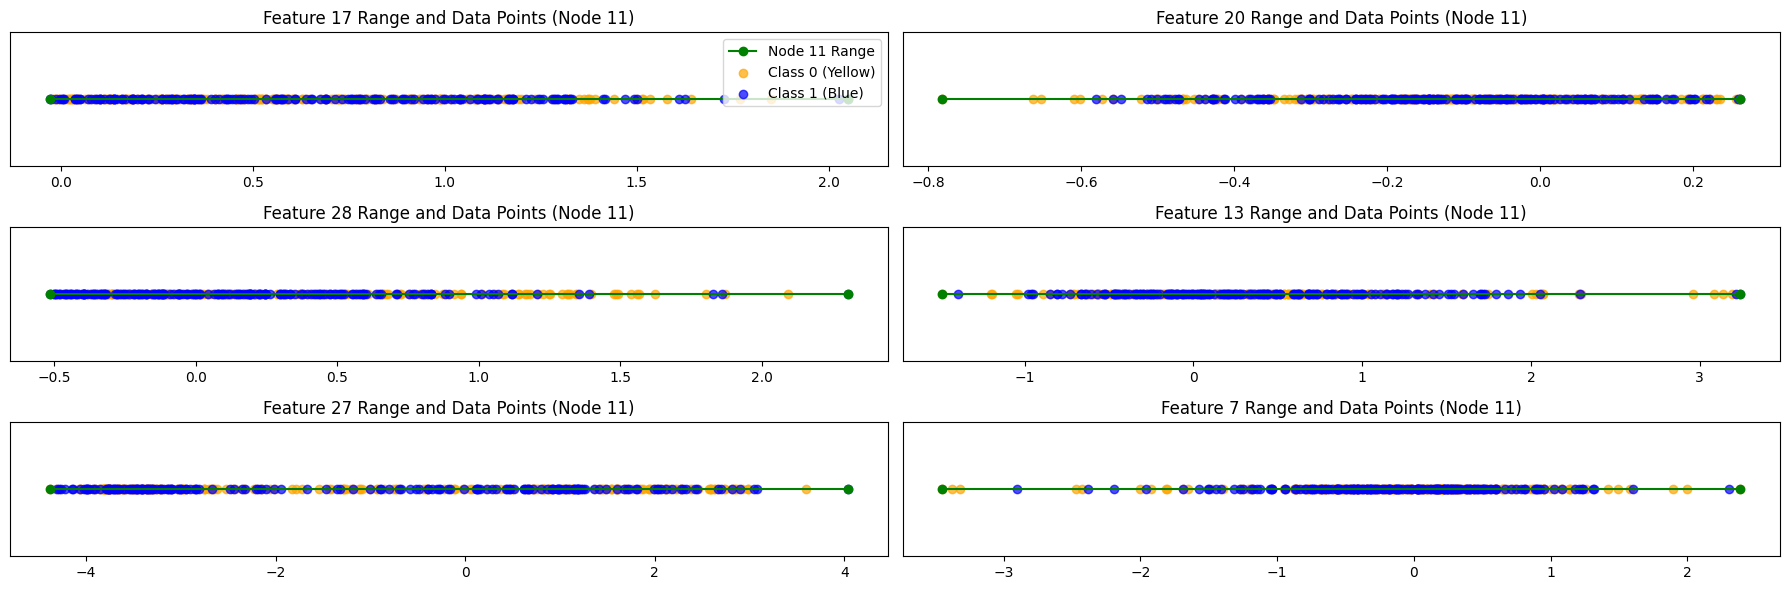

In [20]:
def calculate_node_feature_ranges(tree_model, X_train, y_train, target_node_id, features):
    leaf_ids = tree_model.apply(X_train)
    samples_in_node = X_train.iloc[leaf_ids == target_node_id]
    
    node_ranges = {}
    for feature in features:
        min_value = samples_in_node.iloc[:, feature].min()
        max_value = samples_in_node.iloc[:, feature].max()
        node_ranges[feature] = (min_value, max_value)
        
    return node_ranges, samples_in_node

features_to_plot = [17, 20, 28, 13, 27, 7]
ranges_node_11, node_11_samples = calculate_node_feature_ranges(best_model, X_train, y_train, target_node_id=11, features=features_to_plot)

def plot_feature_ranges_node_11(features, ranges, node_samples, node_labels, point_color_class_0="orange", point_color_class_1="blue"):
    fig, axs = plt.subplots(3, 2, figsize=(18, 6))
    axs = axs.flatten()
    
    for i, feature in enumerate(features):
        feature_range = ranges.get(feature, (None, None))
        
        if feature_range[0] is not None and feature_range[1] is not None:
            axs[i].plot(feature_range, [0, 0], marker='o', color='green', label=f"Node 11 Range")
        
        class_0_points = node_samples[feature][node_labels == 0]
        class_1_points = node_samples[feature][node_labels == 1]
        
        axs[i].scatter(class_0_points, [0] * len(class_0_points), color=point_color_class_0, alpha=0.7, label="Class 0 (Yellow)")
        axs[i].scatter(class_1_points, [0] * len(class_1_points), color=point_color_class_1, alpha=0.7, label="Class 1 (Blue)")
        
        axs[i].set_title(f"Feature {feature} Range and Data Points (Node 11)")
        axs[i].set_yticks([])
    
    axs[0].legend(loc="upper right")
    
    for j in range(i + 1, len(axs)):
        axs[j].axis("off")
        
    plt.tight_layout()
    plt.show()

plot_feature_ranges_node_11(features_to_plot, ranges_node_11, node_11_samples, y_train[leaf_ids == 11])

Best Parameters for Model without Node 11: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Test Accuracy without Node 11: 0.69
Classification Report without Node 11:
               precision    recall  f1-score   support

           0       0.70      0.97      0.81       225
           1       0.46      0.06      0.11        99

    accuracy                           0.69       324
   macro avg       0.58      0.51      0.46       324
weighted avg       0.63      0.69      0.60       324



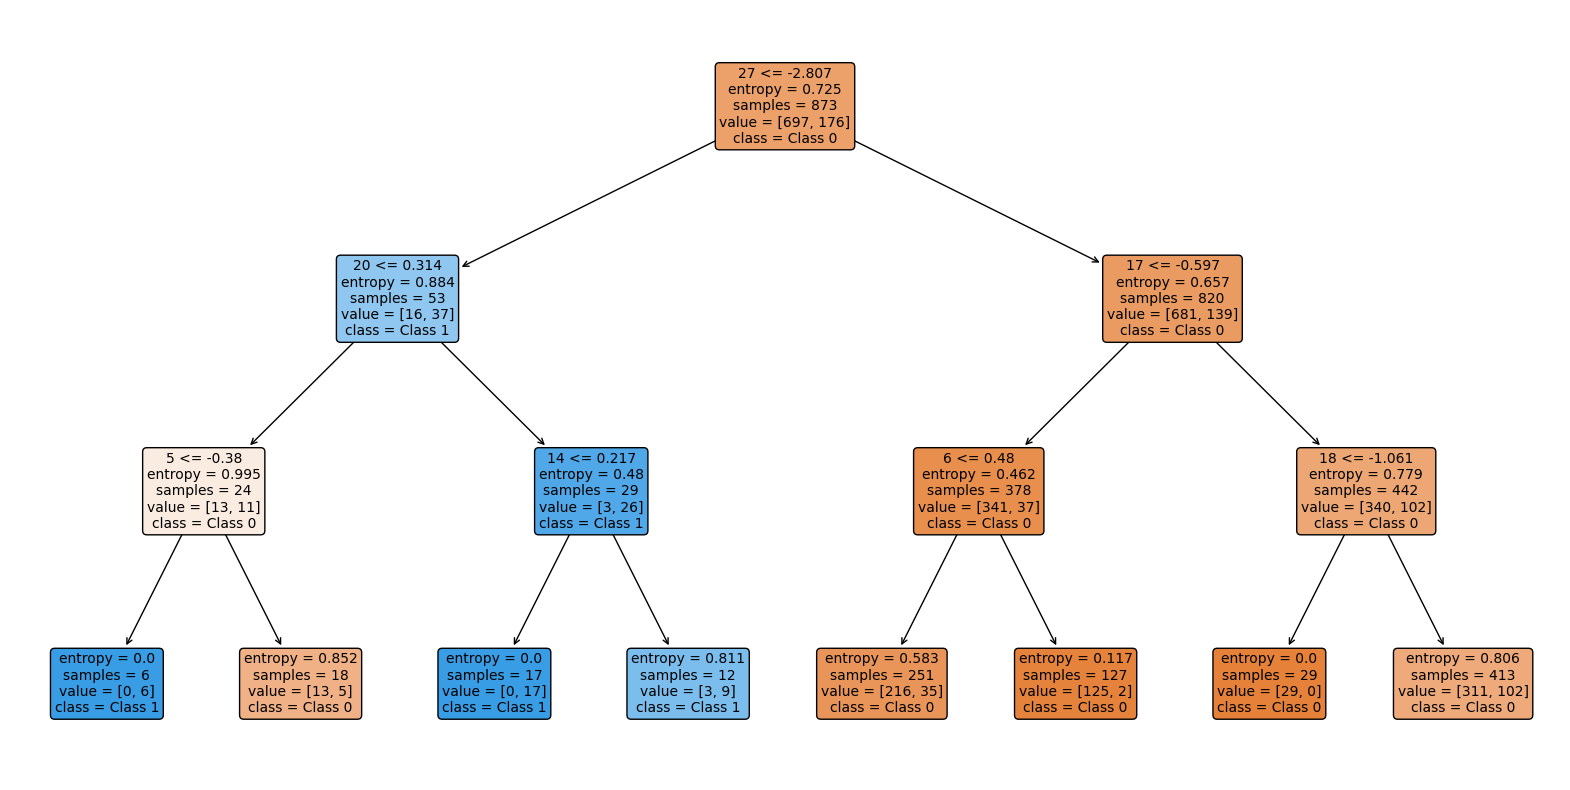

In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Identify samples in Node 11
leaf_ids = best_model.apply(X_train)  # Apply the current model to get leaf ids for each sample
node_11_samples = X_train[leaf_ids == 11]  # Filter samples in Node 11
node_11_indices = node_11_samples.index  # Get the indices of these samples

# Step 2: Remove Node 11 samples from the training data
X_train_filtered = X_train.drop(node_11_indices)  # Remove Node 11 samples
y_train_filtered = y_train.drop(node_11_indices)  # Remove corresponding labels

# Step 3: Perform grid search on the filtered training set
grid_search_filtered = perform_grid_search(X_train_filtered, y_train_filtered, cv=10, seed=42)
print("Best Parameters for Model without Node 11:", grid_search_filtered.best_params_)

# Step 4: Retrain the model with the best parameters found in grid search
best_model_without_node_11 = train_best_model(grid_search_filtered, X_train_filtered, y_train_filtered)

# Step 5: Evaluate the retrained model on the test set
y_pred_filtered = best_model_without_node_11.predict(X_test)
accuracy_filtered = accuracy_score(y_test, y_pred_filtered)
print(f"Test Accuracy without Node 11: {accuracy_filtered:.2f}")
print("Classification Report without Node 11:\n", classification_report(y_test, y_pred_filtered))

# Step 6: Visualize the decision tree without Node 11 samples
def plot_decision_tree(tree_model, feature_names, class_names):
    plt.figure(figsize=(20, 10))
    plot_tree(
        tree_model,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        fontsize=10
    )
    plt.show()

plot_decision_tree(best_model_without_node_11, feature_names=X_train.columns, class_names=['Class 0', 'Class 1'])